In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from time import clock

# Assumptions
## Build the distribution of time spent with a nurse / doctor

In [2]:
class TimeDistribution:
    
    def __init__(self, mean_t=0, sd=0, min_t=0, max_t=0, num=0):
        self.mean = mean_t
        self.sd = sd
        self.min = min_t
        self.max = max_t
        self.num = num

    # Return a list of time following normal distribution
    def time_spend(self) -> list:
        generator = truncnorm((self.min-self.mean)/self.sd, (self.max-self.mean)/self.sd, loc=self.mean, scale=self.sd)
        time = generator.rvs(self.num)
        return time

    # Return the sum of the list of time
    def sum_truncnorm(self) -> float:
        generator = truncnorm((self.min - self.mean) / self.sd, (self.max - self.mean) / self.sd, loc=self.mean, scale=self.sd)
        time = generator.rvs(self.num)
        return sum(time)

## 8 nurses, 4 doctors at any given time, 15-25 patients/hour

In [3]:
nurse = 8
doctor = 4

# Assume 20% of them only to see the nurses
patient = random.randint(15, 25)
patient_nurse = int(patient * 0.2)
patient_nurse_doctor = patient - patient_nurse

# (mean, sd, min, max) variables indicating the time(minutes) a patient needs to spent with a nurse/doctor
mean_time = random.randint(25, 35)
sd = 1
min_time = mean_time - 10
max_time = mean_time + 10

# Nurse and doctor utilization
## Build the function calculating the utilization of the nurses and doctors in one hour, run it multiple times, put the results in two lists

In [4]:
def utilization(mean_t, sd, min_t, max_t, nurse: int, doctor: int, patient: int, patient_both: int):

    # Calculate the total time (minutes) nurses and doctors need to work with patients in one hour
    total_nurse_time = TimeDistribution(mean_t, sd, min_t, max_t, patient).sum_truncnorm()
    total_doctor_time = TimeDistribution(mean_t, sd, min_t, max_t, patient_both).sum_truncnorm()

    # Calculate the utilization values to return
    utilization_nurse = total_nurse_time / (nurse * 60)
    utilization_doctor = total_doctor_time / (doctor * 60)

    return utilization_nurse, utilization_doctor

ut_nurse, ut_doctor = [], []
for i in range(20000):
    utilization_nurse, utilization_doctor = utilization(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse_doctor)
    ut_nurse.append(utilization_nurse)
    ut_doctor.append(utilization_doctor)

## Show the plot of the list of nurse utilization rates: in 20000 simulations, the utilization rates of nurses mostly remains between 1.69 and 1.75

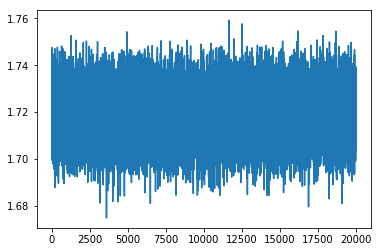

In [5]:
plt.plot(ut_nurse)
plt.show()

## Show the plot of the list of doctor utilization values: in 20000 simulations, the utilization rates of doctors mostly remains between 2.7 and 2.8

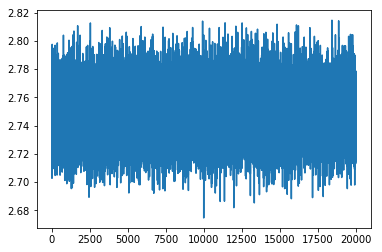

In [6]:
plt.plot(ut_doctor)
plt.show()

# Patients waiting time
## Build a function calculating the average and max waiting time for a nurse and a doctor of a patient

In [7]:
def wait_time(mean_t, sd, min_t, max_t, nurse, doctor, patient, patient_nurse, patient_both):
    
    """Create a dataframe with a list of patient as index, storing the time point data and time spent length data of 
       each patient"""

    # Create a list of patient as [patient_1, patient_2, ..., patient_totalnumberofpatients], in order
    list_patient = []
    for i in range(patient):
        list_patient.append('patient_{}'.format(i+1))

    # The list of data as index, all initial time data as 0, and assume all patients to see both a nurse and a doctor
    df_patients = pd.DataFrame({'Arrival_point': 0, 'Nurse_only': False,
                                'Waiting_nurse': 0, 'Meet_nurse_point': 0,
                                'Seeing_nurse': 0, 'After_nurse_point': 0,
                                'Waiting_doctor': 0, 'Meet_doctor_point': 0,
                                'Seeing_doctor': 0, 'After_doctor_point': 0}, index=list_patient)


    """Deal with 'Arrival_point', 'Nurse_only', 'Seeing_nurse' columns"""
    # Create a list of random numbers that sum to 60 as gaps between every two patients, get patient arrival point
    total_time = 60
    random_arrival = [random.random() for i in range(patient)]
    sum_arrival = sum(random_arrival)
    arrival_time = [total_time * i / sum_arrival for i in random_arrival]
    for i in range(patient):
        df_patients.loc[list_patient[i], 'Arrival_point'] += sum(arrival_time[:i])

    # Randomly select certain number of patients as people only come to see a nurse
    list_patient_nurse_num = random.sample(list(range(patient)), patient_nurse)
    for i in list_patient_nurse_num:
        df_patients.loc['patient_{}'.format(i + 1), 'Nurse_only'] = True

    # Randomly get the list of time patients spending with nurses
    df_patients['Seeing_nurse'] = TimeDistribution(mean_t, sd, min_t, max_t, patient).time_spend()

    
    """Create two nurse and doctor arrays, deal with 'Meet_nurse_point', 'Waiting_nurse', 'After_nurse_point' columns, 
       update nurse array"""
    # Create two arrays for nurses and doctors, each item represents the available time point of a nurse or a doctor
    arr_nurse = np.zeros(nurse)
    arr_doctor = np.zeros(doctor)

    for i in range(patient):
        # Compare the min value in nurse array and the arrival point of each patient to get'Meet_nurse_point'
        if min(arr_nurse) <= df_patients.loc[list_patient[i], 'Arrival_point']:
            df_patients.loc[list_patient[i], 'Meet_nurse_point'] = df_patients.loc[list_patient[i], 'Arrival_point']
        else:
            df_patients.loc[list_patient[i], 'Meet_nurse_point'] = min(arr_nurse)

        df_patients.loc[list_patient[i], 'Waiting_nurse'] = df_patients.loc[list_patient[i], 'Meet_nurse_point'] - df_patients.loc[list_patient[i], 'Arrival_point']
        df_patients.loc[list_patient[i], 'After_nurse_point'] = df_patients.loc[list_patient[i], 'Meet_nurse_point'] + df_patients.loc[list_patient[i], 'Seeing_nurse']

        # Update the value of the nurse in the array, store his/her next available point in the array
        arr_nurse[np.argmin(arr_nurse)] += df_patients.loc[list_patient[i], 'Seeing_nurse']

        
    """Deal with 'Meet_doctor_point', 'Waiting_doctor', 'Seeing_doctor', 'After_nurse_point' columns, update doctor 
       array during iterating, similar to nurse columns"""
    # Select patients only to see a nurse, put None to their doctor-related cells
    list_patient_nurse = [p for p in df_patients[df_patients['Nurse_only'] == True].index]
    for i in range(patient_nurse):
        df_patients.loc[list_patient_nurse[i], 'Waiting_doctor':'After_doctor_point'] = None

    # Randomly put time periods to the 'See_doctor' cells of people to see a doctor
    list_patient_both = [p for p in df_patients[df_patients['Nurse_only'] == False].index]
    time_doctor = TimeDistribution(mean_t, sd, min_t, max_t, patient_both).time_spend()
    for i in range(patient_both):
        df_patients.loc[list_patient_both[i], 'Seeing_doctor'] = time_doctor[i]

    for i in range(patient_both):
        # Compare the min value in doctor array and the After_nurse_point of each patient, get 'Meet_doctor_point'
        if min(arr_doctor) <= df_patients.loc[list_patient_both[i], 'After_nurse_point']:
            df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] = df_patients.loc[list_patient_both[i], 'After_nurse_point']
        else:
            df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] = min(arr_doctor)

        df_patients.loc[list_patient_both[i], 'Waiting_doctor'] = df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] - df_patients.loc[list_patient_both[i], 'After_nurse_point']
        df_patients.loc[list_patient_both[i], 'After_doctor_point'] = df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] + df_patients.loc[list_patient_both[i], 'Seeing_doctor']

        # Update the value of the doctor in the array, store his/her next available point in the array
        arr_doctor[np.argmin(arr_doctor)] += df_patients.loc[list_patient_both[i], 'Seeing_doctor']


    """After building the dataframs, get the average and max values of Waiting_nurse and Wating_doctor columns to return"""

    average_wait_nurse = round(df_patients['Waiting_nurse'].mean(), 2)
    max_wait_nurse = round(df_patients['Waiting_nurse'].max(), 2)
    average_wait_doctor = round(df_patients['Waiting_doctor'].sum() / patient_both, 2)
    max_wait_doctor = round(df_patients['Waiting_doctor'].max(), 2)

    return average_wait_nurse, max_wait_nurse, average_wait_doctor, max_wait_doctor, df_patients

## Show one example of the dataframe built in this process

In [8]:
wait_time(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse, patient_nurse_doctor)[-1]

,Arrival_point,Nurse_only,Waiting_nurse,Meet_nurse_point,Seeing_nurse,After_nurse_point,Waiting_doctor,Meet_doctor_point,Seeing_doctor,After_doctor_point
patient_1,0.000000,False,0.000000,0.000000,33.285957,33.285957,0.000000,33.285957,31.511067,64.797024
patient_2,0.569659,False,0.000000,0.569659,33.735008,34.304667,0.000000,34.304667,32.752009,67.056676
patient_3,1.004201,False,0.000000,1.004201,33.841669,34.845870,0.000000,34.845870,35.028845,69.874714
patient_4,2.764229,False,0.000000,2.764229,33.746299,36.510528,0.000000,36.510528,31.492116,68.002643
patient_5,2.809545,True,0.000000,2.809545,33.263874,36.073418,NaN,NaN,NaN,NaN
patient_6,4.378056,False,0.000000,4.378056,32.564702,36.942758,0.000000,36.942758,33.033230,69.975988
patient_7,7.799283,False,0.000000,7.799283,32.251454,40.050737,0.000000,40.050737,33.231075,73.281812
patient_8,9.166666,False,0.000000,9.166666,32.584714,41.751380,0.000000,41.751380,31.975156,73.726536
patient_9,10.065162,False,22.186292,32.251454,33.887948,66.139402,0.000000,66.139402,33.339773,99.479175
patient_10,12.283697,False,20.281006,32.564702,32.537332,65.102035,0.000000,65.102035,34.410129,99.512164


## Run the wait_time function multiple times, put the results in several lists

In [9]:
ave_nurse, max_nurse, ave_doctor, max_doctor = [], [], [], []
for i in range(20000):
    ave_n, max_n, ave_d, max_d = wait_time(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse, patient_nurse_doctor)[:4]
    ave_nurse.append(ave_n)
    max_nurse.append(max_n)
    ave_doctor.append(ave_d)
    max_doctor.append(max_d)

## Show the plot of the list of average waiting time for a nurse: in 20000 simulations, the average waiting time mostly remains between 7 minutes and 13 minutes

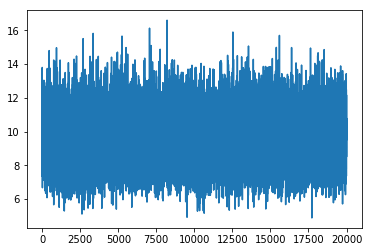

In [10]:
plt.plot(ave_nurse)
plt.show()

## Show the plot of the list of maximum waiting time for a nurse: in 20000 simulations, the maximum waiting time mostly remains between 35 minutes and 42 minutes

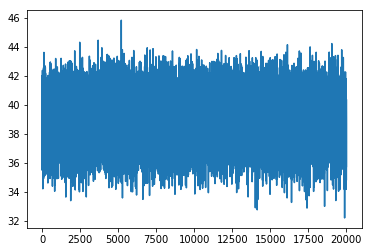

In [11]:
plt.plot(max_nurse)
plt.show()

## Show the plot of the list of average waiting time for a doctor: in 20000 simulations, the average waiting time mostly remains between 4 minutes and 11 minutes

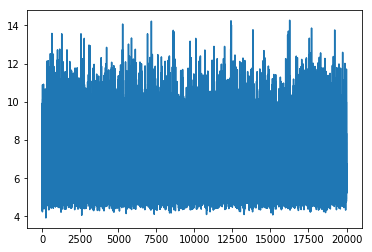

In [12]:
plt.plot(ave_doctor)
plt.show()

## Show the plot of the list of maximum waiting time for a doctor: in 20000 simulations, the maximum waiting time mostly remains between 30 minutes and 36 minutes

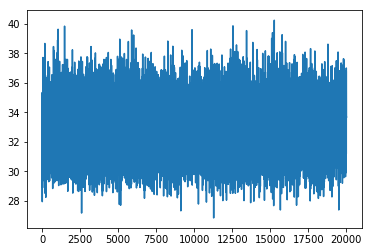

In [13]:
plt.plot(max_doctor)
plt.show()